In [1]:
from slugify import slugify
import numpy as np
import pandas as pd
import scipy.stats

import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns

import arviz as az
import pymc as pm
import xarray as xr

import json

# import dcs
# import priors
import pgamma

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
ref_prior = (1, 100)

# location data: characteristices of the sensors
bi = pd.read_csv("dc_locations.csv")
bi["sensor"] = bi["sensor"].map(lambda x: slugify(x))

# the guesses from the students
guessed = pd.read_csv('guesses.csv')

report_name="Lac Léman"
# the column name in the survey data and
# location data where the feature_name will
# be found
feature="feature"
# the region of interest
feature_name="lac-leman"
# retrieve the current data and the most common codes for the region of interest
report_leman, codes = pgamma.get_most_common_and_aggregated_feature_report(report_name=report_name, pg=feature, pgn=feature_name)
# get the report ot the most common codes
dr = report_leman.make_report_code_summary()
# the columns need to be renamed for this usage
de = dr[1:]
di = pd.DataFrame(de)
di.columns = dr[0]
# limit the report to only the codes of interest
di = di[di.Code.isin(codes)]
xi = di[['Code', 'Description', 'N pieces', 'pcs/m','Fail rate']]
# export to .json
x = xi.to_dict(orient="records")
with open("most_common_json.json", "w") as afile:
    json.dump(x, afile)

regional_surveys = ['Tolochenaz',
     'Bourg-en-Lavaux', 
     'Morges', 
     'Allaman', 
     'Lausanne', 
     'Saint-Sulpice (VD)', 
     'Préverenges', 
     'Rolle',
    ]

# the uptodate data for lac leman
eix = pd.read_csv("ei_uptotdate.csv")
eix["date"] = pd.to_datetime(eix["date"])

# the data prior to the sample date
ei = eix[eix["date"] < "2022-10-01"]

# mask for the most common codes
code_mask = (ei.code.isin(codes))

# regressors
variables = ["lake", "grand-lac", 'Saint-Sulpice (VD)']

# the columns of interest
columns = ["pcs_m","quantity", "group", "code", "loc_date", "sensor", *variables]

d = ei[code_mask].copy()

regional_mask = d.city.isin(regional_surveys)

# mask the regional data for the municipal data
city_mask = (d.city == 'Saint-Sulpice (VD)')
# the easiest way to get summary data from IQAASL
# is to use the module for that purpose


log started


### Implementing the model in PyMC

This is an implementation of negative binomial regression with litter survey data. The subject is introduced at www.hammerdirt.ch 

The model was originally used on the survey day with EPFL students. The predictions of the model are compared against what the students guessed and what was found. Another version of this model is available in hierarchical_models.ipynb . It is subjected to the same tests.

The implementation and testing of these models is the evolution of a project started seven years ago.

In [2]:
def summary_percode(code, results):
    d = results[code][0]
    e = az.summary(d, var_names=["intercept", "slopes"], kind='stats')
    v = np.exp(e)
    vi = v.product(axis=0)
    vi["code"] = code
    vi["predicted-mean"] = results[code][0].posterior_predictive.found.mean().to_numpy().item()
    return vi

def collect_summaries(codes, results, location):
    
    vis = []
    for code in codes:
        f = summary_percode(code, results)
        f["location"] = location
        vis.append(f)
    return vis


def select_for_a_code(code, data):    
    d = data[data.code == code][["pcs_m", "sensor", *variables]].copy()
    d.reset_index(inplace=True, drop = True)
    return d



def add_location_column(location, data):
    data[location] = False
    data.loc[data['sensor'] == location, location] = True
    return data

def make_a_glm(location, data):
    
    c2 = {"regressor": [location, "city","region:lake"], "obs_idx":data.index}

    with pm.Model(coords=c2) as LakeModelX:
        a = pm.Normal("intercept", mu=0, sigma=1)
        b = pm.Normal("slopes", mu=0, sigma=1, dims="regressor")
        alpha = pm.Exponential("alpha", 1)

        
        C = pm.ConstantData(location, data[location].to_numpy(), dims="obs_idx")
        D = pm.ConstantData("city", data['Saint-Sulpice (VD)'].to_numpy(), dims="obs_idx")
        E = pm.ConstantData("region",  data["grand-lac"].to_numpy(), dims="obs_idx")
        F = pm.ConstantData("lake",  data["lake"].to_numpy(), dims="obs_idx")
        
        λ =pm.Deterministic("param", pm.math.exp(a + b[0]*C + b[1]*D + b[2]*F*E), dims="obs_idx")
        
        y = pm.NegativeBinomial("found", mu=λ, alpha=alpha, observed=data.pcs_m.to_numpy(), dims="obs_idx")

        sampled_r = pm.sample(1000, tune=1000)
        pm.sample_posterior_predictive(sampled_r,extend_inferencedata=True, random_seed=rng)
        
        return sampled_r, LakeModelX

def make_predictions(locations, codes, data):
    
    results = {}
    for loc in locations:
        r = {loc:{}}
        for code in codes:
            dtx = select_for_a_code(code, data)
            
            d = add_location_column(loc, dtx)
           
            sampled, model = make_a_glm(loc, d)
            r[loc].update({code:[sampled, model]})
        results.update(r)
    
    return results, d


d = ei[code_mask].copy()
 
d["lake"] = True
d[variables[1]] = regional_mask
d[variables[2]] = city_mask

combined = d.copy()    

In [3]:
abeach = "parc-des-pierrettes"
aregion = 'Saint-Sulpice (VD)'
xhp = make_predictions([abeach], ["Gfrags"], combined)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [4]:
abeach = "plage-de-st-sulpice"
xh = make_predictions([abeach], ["Gfrags"], combined)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [5]:
# posterior dist and model parc-des-pierretts
h, hmodel = xhp
# posterior dist and model plage-de-st-sulpice
f, fmodel = xh

### Model results

There is a small difference in the mean value between one beach and the other.

In [6]:
asummary = np.exp(az.summary(h["parc-des-pierrettes"]["Gfrags"][0], var_names=["intercept", "slopes"], kind='stats'))
asummary

,mean,sd,hdi_3%,hdi_97%
intercept,108.962087,1.100759,89.927159,129.024202
slopes[parc-des-pierrettes],0.544439,1.969934,0.161702,1.942547
slopes[city],2.021824,1.472556,0.994018,4.224919
slopes[region:lake],1.670295,1.248571,1.089806,2.486808


In [7]:
asummary = np.exp(az.summary(f["plage-de-st-sulpice"]["Gfrags"][0], var_names=["intercept", "slopes"], kind='stats'))
asummary

,mean,sd,hdi_3%,hdi_97%
intercept,109.180230,1.101860,91.652110,132.555311
slopes[plage-de-st-sulpice],0.729059,1.868246,0.239548,2.418143
slopes[city],2.044187,1.487356,0.943650,4.195447
slopes[region:lake],1.675313,1.238623,1.108491,2.481839


### Guessed versus predicted

The forecasted values have a lower sum of squared diffences ( $\sum \sqrt{(y_{predicted} - y_{found})²}$ ) than the guessed values ( $\sum \sqrt{(y_{guessed} - y_{found})²}$ ).

In [11]:
summary_columns = ['mean', 'sd', 'hdi_3%', 'hdi_97%', 'code', 'predicted-mean', 'location']

b = collect_summaries(["Gfrags"], h['parc-des-pierrettes'], 'parc-des-pierrettes')
g = collect_summaries(["Gfrags"], f['plage-de-st-sulpice'], 'plage-de-st-sulpice')

ppps = pd.concat(b, axis=1).T
pdp = ppps[summary_columns].copy()

pspg = pd.concat(g, axis=1).T
psp = pspg[summary_columns].copy()

predictions =  pd.concat([psp, pdp])
predictions["location"] = predictions["location"].map(lambda x:  f"{x}-predicted")

gsd = pd.read_csv("guessed_combined.csv")
gsd.rename(columns={"beach":"sensor"}, inplace=True)
gsd = gsd.sort_values(by="code")

eixd = eix[(eix["date"] > "2022-10-01") & (eix.code.isin(combined.code.unique()))].copy()
eixd["sensor"] = eixd.sensor.map(lambda x: f"{x}-found")
eixd["pcs_m"] = (eixd.quantity/41)*100
eixd = eixd.sort_values(by="code")

predictions = predictions.sort_values(by="code")
predictions.rename(columns={"location":"sensor"}, inplace=True)

# make maps to found and guessed values
def select_and_aggregate_records(data, location, column):
    d = data[data.sensor == location].groupby("code").pcs_m.mean()
    return d

def make_amap_to_found_code_values(data, location):
    d = data[eixd.sensor == location][["code", "pcs_m"]].set_index("code", drop=True)
    return d["pcs_m"]

def add_guessed_found_column(d, amap, col_name):
    d[col_name] = d.code.map(lambda x: amap.loc[x])
    return d

def the_difference_between_guessed_predicted(d):
    d["guessed-diff"] = d["guessed"] - d["found"]
    d["predicted-diff"] = d["predicted-mean"] - d["found"]
    return d

def the_diiference_squared(d, location, guess_map, found_map):
    
    data = d[d.sensor == location].copy()
    data = add_guessed_found_column(data,  guess_map, "guessed")
    data = add_guessed_found_column(data, found_map, "found")
    data = the_difference_between_guessed_predicted(data)
    data["abs_guessed"] = data["guessed-diff"].abs()
    data["abs_predicted"] =data["predicted-diff"].abs()
    data["guessed <= predicted"] = data["abs_guessed"] <= data["abs_predicted"]
       
    return data
    
# the predicted, guessed and found quantities for each beach
# plage de st sulpice
gsp = select_and_aggregate_records(gsd,"plage-de-st-sulpice-guessed", "code")
exf_ps = make_amap_to_found_code_values(eixd,  "plage-de-st-sulpice-found")
pred_sp = the_diiference_squared(predictions,  "plage-de-st-sulpice-predicted", gsp, exf_ps) 

# parc des pierrettes
exf_pp = make_amap_to_found_code_values(eixd,  "parc-des-pierrettes-found")
gpp = select_and_aggregate_records(gsd, "parc-des-pierrettes-guessed", "code")
pred_pp = the_diiference_squared(predictions,  'parc-des-pierrettes-predicted', gpp, exf_pp) 

# a quick comparison of the sum of the differences
dif_summPP=pred_pp[["abs_guessed", "abs_predicted"]].sum()
dif_summSP=pred_sp[["abs_guessed", "abs_predicted"]].sum()

# format and export results
x1 = pred_pp[['code', 'predicted-mean', 'guessed', 'found', "guessed-diff", "predicted-diff"]].to_dict(orient="records")
x2 = pred_sp[['code', 'predicted-mean', 'guessed', 'found', "guessed-diff", "predicted-diff"]].to_dict(orient="records")

# with open("guessed_predicted_found_pp.json", "w") as afile:
#     json.dump(x1, afile)
# with open("guessed_predicted_found_ps.json", "w") as afile:
#     json.dump(x2, afile)

In [12]:
# the sum of the abosolute value (distance) of guessed or predicted - found
print("parc-des-pierrettes")
print(dif_summPP)
print("plage-de-st-sulpice")
print(dif_summSP)

parc-des-pierrettes
abs_guessed       42.120596
abs_predicted    191.195566
dtype: object
plage-de-st-sulpice
abs_guessed      120.487805
abs_predicted    141.152137
dtype: object


The number of $guessed <= predicted$ is 10/48 or 80% of the mean forecasted values were closer than the guessed values

In [13]:
# the number of times that the difference of guessed - found was less than or equal to predicted
print("parc-des-pierrettes")

print(f"guessed <= predicted: {pred_pp['guessed <= predicted'].sum()}")

print("plage-de-st-sulpice")
print(f"guessed <= predicted:{pred_sp['guessed <= predicted'].sum()}")


parc-des-pierrettes
guessed <= predicted: 1
plage-de-st-sulpice
guessed <= predicted:1


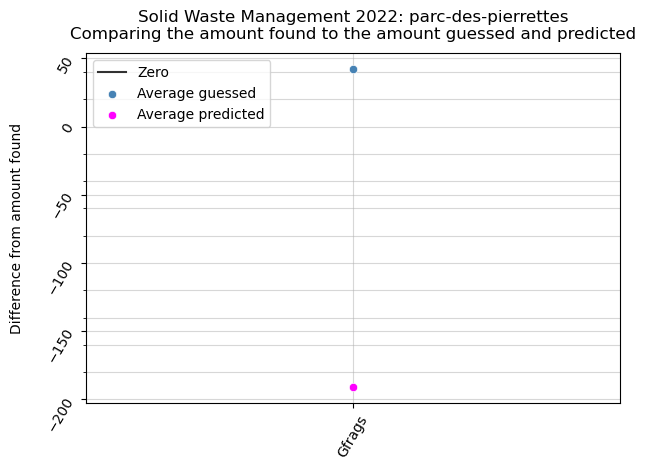

In [14]:
fig, ax = plt.subplots()


data = pred_pp[["code", "found", "guessed-diff", "predicted-diff"]].copy()
x= data["code"].values
y=data["guessed-diff"].values
y2 = data["predicted-diff"].values

y_sqd = np.sqrt(y**2)
y2_sqd = y2**2

ty = [np.sqrt(x) for x in y2_sqd]

xmax = len(x)
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(20))
ax.grid(which='both', axis='both', alpha=0.5)
sns.lineplot(x=x, y=np.zeros(len(x)), color="black", alpha=0.8, label="Zero", zorder=0)
sns.scatterplot(x=x, y=y, label = "Average guessed", color="steelblue", ax=ax, zorder=2)
sns.scatterplot(x=x, y=y2, label = "Average predicted", color="magenta", ax=ax, zorder=2)

ax.tick_params(axis="both", which="both", labelsize=10, rotation=60)
ax.set_ylabel("Difference from amount found", labelpad=15)
ax.set_title("Solid Waste Management 2022: parc-des-pierrettes\nComparing the amount found to the amount guessed and predicted", pad=10)
ax.legend(bbox_to_anchor=(0,1), loc="upper left")


plt.tight_layout()
plt.savefig("differences_predicted_guessed_pp.jpeg", dpi=300)
plt.show()

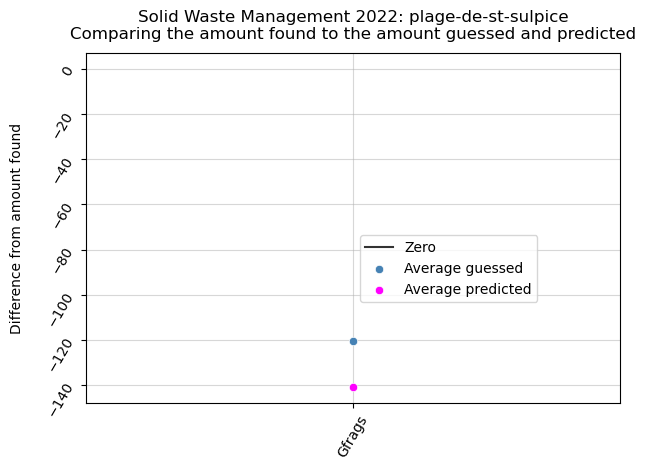

In [15]:
fig, ax = plt.subplots()


data = pred_sp[["code", "found", "guessed-diff", "predicted-diff"]].copy()
x= data["code"].values
y=data["guessed-diff"].values
y2 = data["predicted-diff"].values

y_sqd = np.sqrt(y**2)
y2_sqd = y2**2

ty = [np.sqrt(x) for x in y2_sqd]

xmax = len(x)
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(20))
ax.grid(which='both', axis='both', alpha=0.5)

sns.lineplot(x=x, y=np.zeros(len(x)), color="black", alpha=0.8, label="Zero", zorder=0)
sns.scatterplot(x=x, y=y, label = "Average guessed", color="steelblue", ax=ax, zorder=2)
sns.scatterplot(x=x, y=y2, label = "Average predicted", color="magenta", ax=ax, zorder=2)

ax.tick_params(axis="both", which="both", labelsize=10, rotation=60)
ax.set_ylabel("Difference from amount found", labelpad=15)
ax.set_title("Solid Waste Management 2022: plage-de-st-sulpice\nComparing the amount found to the amount guessed and predicted", pad=10)
ax.legend(bbox_to_anchor=(.5,.5), loc="upper left")
ax.grid(which='major', axis='both', alpha=0.5)
plt.tight_layout()
plt.savefig("differences_predicted_guessed_sp.jpeg", dpi=300)
plt.show()

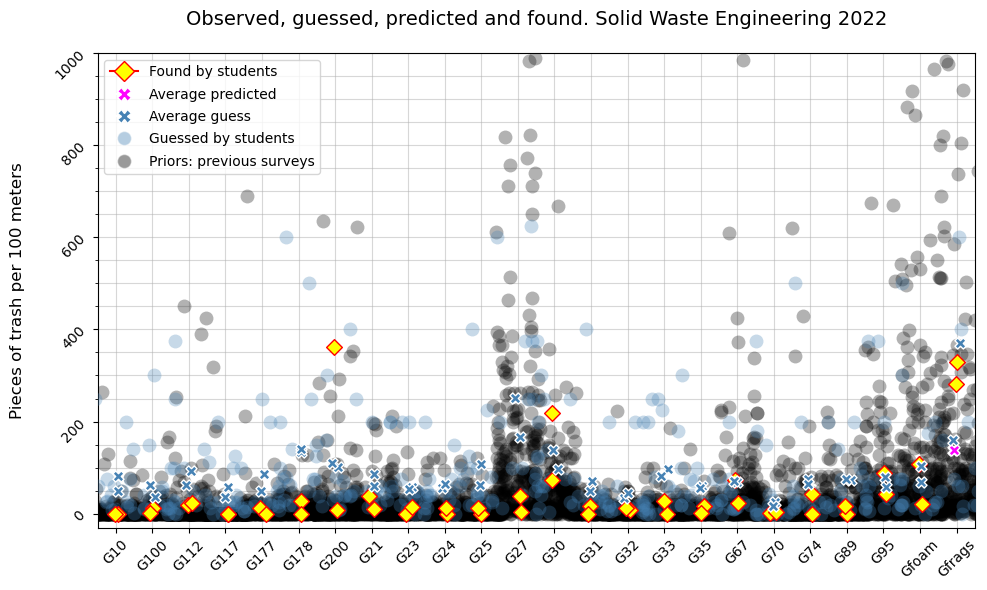

In [16]:
fig, ax = plt.subplots(figsize=(10,6))

g_mean = gsd.groupby(["sensor", "code"], as_index=False).pcs_m.mean()


legend_elements = [Line2D([0], [0], marker="D", color='red', markerfacecolor='yellow', markersize=10, label='Found by students'),
                   Line2D([0], [0], marker='X', color='white', label='Average predicted', markerfacecolor='magenta', markersize=10),
                    Line2D([0], [0], marker='X', color='white', label='Average guess', markerfacecolor='steelblue', markersize=10),
                    Line2D([0], [0], marker='o', markerfacecolor='steelblue', color='w',label='Guessed by students', markersize=10, alpha=0.4),
                   Line2D([0], [0], marker='o', markerfacecolor='black', color='w',label='Priors: previous surveys', markersize=10, alpha=0.4),
                 ]
                  
               
sns.stripplot(data=combined, x="code", y="pcs_m", color="black", label="all_values", alpha=0.3, ax=ax, jitter=.6, size=10)
sns.stripplot(data=gsd, x="code", y="pcs_m", color="steelblue", alpha=0.3, ax=ax, jitter=.6, size=10)


sns.stripplot(data=predictions, x="code", y="predicted-mean",  size=8, edgecolor="white", color="magenta", marker="X", linewidth=1, ax=ax)
sns.stripplot(data=eixd, x="code", y="pcs_m", size=8, edgecolor="red", color="yellow", linewidth=1,  marker="D",  ax=ax)

sns.stripplot(data=g_mean, y="pcs_m", x="code", size=8, edgecolor="white", color="steelblue", marker="X", linewidth=1, ax=ax)

ax.tick_params(axis="both", which="both", labelsize=10, rotation=45)
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
ax.grid(which='both', axis='both', alpha=0.5)

ax.set_title("Observed, guessed, predicted and found. Solid Waste Engineering 2022", fontsize=14, pad=20)
ax.set_ylabel("Pieces of trash per 100 meters", labelpad=20, fontsize=12)
ax.set_xlabel("")
ax.set_ylim(-30, 1000)
ax.get_legend().remove()
ax.grid(which='both', axis='y', alpha=0.5)

ax.legend(handles=legend_elements, loc='upper left', labelspacing=.6)
plt.tight_layout()

plt.savefig("results.jpg", dpi=300)
plt.show()

In [18]:
code_mask = (eix.code.isin(codes))
e = eix[code_mask].copy()

regional_mask = e.city.isin(regional_surveys)

# mask the regional data for the municipal data
city_mask = (e.city == 'Saint-Sulpice (VD)')
e["lake"] = True
e[variables[1]] = regional_mask
e[variables[2]] = city_mask

In [19]:
abeach = "parc-des-pierrettes"
aregion = 'Saint-Sulpice (VD)'
updtd_pp = make_predictions([abeach], ["Gfrags"], e)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [20]:
abeach = "plage-de-st-sulpice"
updated_sp = make_predictions([abeach], ["Gfrags"], e)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [21]:
tpp, tpp_model = updtd_pp

asummary = np.exp(az.summary(tpp["parc-des-pierrettes"]["Gfrags"][0], var_names=["intercept", "slopes"], kind='stats'))
asummary

,mean,sd,hdi_3%,hdi_97%
intercept,109.398809,1.104066,92.111518,134.424137
slopes[parc-des-pierrettes],0.612626,1.864513,0.181772,1.873859
slopes[city],2.040102,1.454991,1.035620,4.195447
slopes[region:lake],1.665291,1.246077,1.102963,2.516830


In [22]:
tsp, tsp_model = updated_sp
asummary = np.exp(az.summary(tsp["plage-de-st-sulpice"]["Gfrags"][0], var_names=["intercept", "slopes"], kind='stats'))
asummary

,mean,sd,hdi_3%,hdi_97%
intercept,108.962087,1.101860,89.927159,129.153291
slopes[plage-de-st-sulpice],0.720363,1.773580,0.252840,2.104336
slopes[city],2.031958,1.471085,1.032518,4.344888
slopes[region:lake],1.683711,1.256085,1.074655,2.516830


In [24]:
summary_columns = ['mean', 'sd', 'hdi_3%', 'hdi_97%', 'code', 'predicted-mean', 'location']

b = collect_summaries(["Gfrags"], tpp['parc-des-pierrettes'], 'parc-des-pierrettes')
g = collect_summaries(["Gfrags"], tsp['plage-de-st-sulpice'], 'plage-de-st-sulpice')

tppx = pd.concat(b, axis=1).T
tpps = tppx[summary_columns].copy()

tpspx = pd.concat(g, axis=1).T
tpsp = tpspx[summary_columns].copy()

upd_pred =  pd.concat([tpsp, tpps])
upd_pred["location"] = upd_pred["location"].map(lambda x:  f"{x}-predicted")
upd_pred.rename(columns={"location":"sensor"}, inplace=True)
upd_pred.sort_values(by="code", inplace=True)


upd_sp = the_diiference_squared(upd_pred,  "plage-de-st-sulpice-predicted", gsp, exf_ps) 


upd_pp = the_diiference_squared(upd_pred,  'parc-des-pierrettes-predicted', gpp, exf_pp) 

# a quick comparison of the sum of the differences
dif_summPP=upd_pp[["abs_guessed", "abs_predicted"]].sum()
dif_summSP=upd_sp[["abs_guessed", "abs_predicted"]].sum()

In [25]:
# the sum of the abosolute value (distance) of guessed or predicted - found
print("parc-des-pierrettes")
print(dif_summPP)
print("plage-de-st-sulpice")
print(dif_summSP)

parc-des-pierrettes
abs_guessed       42.120596
abs_predicted    188.794291
dtype: object
plage-de-st-sulpice
abs_guessed      120.487805
abs_predicted     139.40937
dtype: object


In [26]:
# the number of times that the difference of guessed - found was less than or equal to predicted
print("parc-des-pierrettes")

print(f"guessed <= predicted: {upd_pp['guessed <= predicted'].sum()}")

print("plage-de-st-sulpice")
print(f"guessed <= predicted:{upd_sp['guessed <= predicted'].sum()}")


parc-des-pierrettes
guessed <= predicted: 1
plage-de-st-sulpice
guessed <= predicted:1


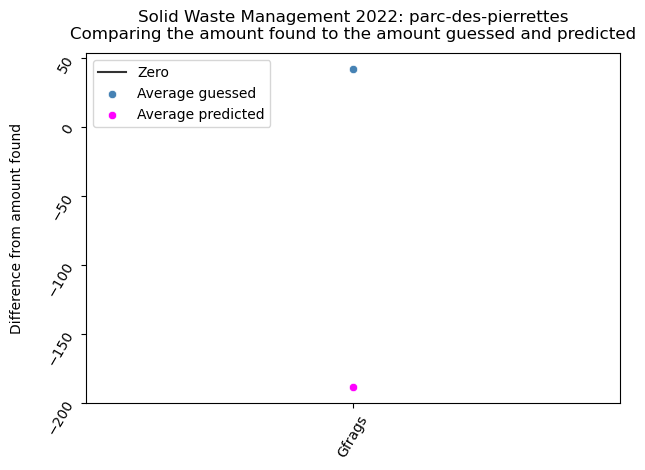

In [27]:
fig, ax = plt.subplots()


data = upd_pp[["code", "found", "guessed-diff", "predicted-diff"]].copy()
x= data["code"].values
y=data["guessed-diff"].values
y2 = data["predicted-diff"].values

y_sqd = np.sqrt(y**2)
y2_sqd = y2**2

ty = [np.sqrt(x) for x in y2_sqd]

xmax = len(x)

sns.lineplot(x=x, y=np.zeros(len(x)), color="black", alpha=0.8, label="Zero", zorder=0)
sns.scatterplot(x=x, y=y, label = "Average guessed", color="steelblue", ax=ax, zorder=2)
sns.scatterplot(x=x, y=y2, label = "Average predicted", color="magenta", ax=ax, zorder=2)

ax.tick_params(axis="both", which="both", labelsize=10, rotation=60)
ax.set_ylabel("Difference from amount found", labelpad=15)
ax.set_title("Solid Waste Management 2022: parc-des-pierrettes\nComparing the amount found to the amount guessed and predicted", pad=10)
ax.legend(bbox_to_anchor=(0,1), loc="upper left")
plt.tight_layout()
plt.savefig("differences_predicted_guessed_pp.jpeg", dpi=300)
plt.show()

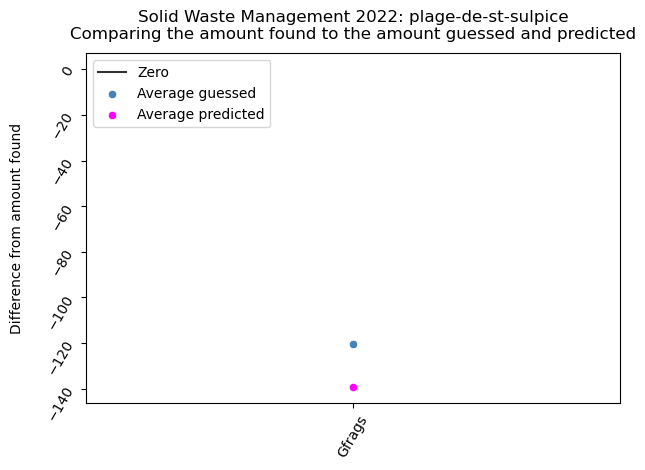

In [28]:
fig, ax = plt.subplots()


data = upd_sp[["code", "found", "guessed-diff", "predicted-diff"]].copy()
x= data["code"].values
y=data["guessed-diff"].values
y2 = data["predicted-diff"].values

y_sqd = np.sqrt(y**2)
y2_sqd = y2**2

ty = [np.sqrt(x) for x in y2_sqd]

xmax = len(x)

sns.lineplot(x=x, y=np.zeros(len(x)), color="black", alpha=0.8, label="Zero", zorder=0)
sns.scatterplot(x=x, y=y, label = "Average guessed", color="steelblue", ax=ax, zorder=2)
sns.scatterplot(x=x, y=y2, label = "Average predicted", color="magenta", ax=ax, zorder=2)

ax.tick_params(axis="both", which="both", labelsize=10, rotation=60)
ax.set_ylabel("Difference from amount found", labelpad=15)
ax.set_title("Solid Waste Management 2022: plage-de-st-sulpice\nComparing the amount found to the amount guessed and predicted", pad=10)
ax.legend(bbox_to_anchor=(0,1), loc="upper left")
plt.tight_layout()
plt.savefig("differences_predicted_guessed_pp.jpeg", dpi=300)
plt.show()

In [29]:
def make_a_glm(location, data):
    
    c2 = {"regressor": [location, "city", "region"], "intercepts":["r"], "obs_idx":data.index}

    with pm.Model(coords=c2) as LakeModelX:
        a = pm.Normal("intercept", mu=0, sigma=1, dims="intercepts")
        b = pm.Normal("slopes", mu=0, sigma=1, dims="regressor")
        alpha = pm.Exponential("alpha", 1)

        
        C = pm.ConstantData(location, data[location].to_numpy(), dims="obs_idx")
        D = pm.ConstantData("city", data['Saint-Sulpice (VD)'].to_numpy(), dims="obs_idx")
        E = pm.ConstantData("region",  data["grand-lac"].to_numpy(), dims="obs_idx")
        O = pm.ConstantData("observed", data["pcs_m"].to_numpy(), dims="obs_idx")
        
        
        λ =pm.Deterministic("param", pm.math.exp(a*E + b[0]*C + b[1]*D), dims="obs_idx")
        
        y = pm.NegativeBinomial("found", mu=λ, alpha=alpha, observed=O, dims="obs_idx")

        sampled_r = pm.sample(1000, tune=1000)
        pm.sample_posterior_predictive(sampled_r,extend_inferencedata=True, random_seed=rng)
        
        return sampled_r, LakeModelX

def make_predictions(locations, codes, data):
    
    results = {}
    for loc in locations:
        r = {loc:{}}
        for code in codes:
            dtx = select_for_a_code(code, data)
            
            d = add_location_column(loc, dtx)
           
            sampled, model = make_a_glm(loc, d)
            r[loc].update({code:[sampled, model]})
        results.update(r)
    
    return results, d

abeach = "parc-des-pierrettes"
aregion = 'Saint-Sulpice (VD)'
newd = e[e["grand-lac"] == True].copy()
no_lakepp = make_predictions([abeach], codes, newd)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.8819, but should be close to 0.8. Try to increase the number of tuning steps.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [30]:
abeach = "plage-de-st-sulpice"
no_lakesp = make_predictions([abeach], codes, newd)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [31]:
nlpp, nlpp_model = no_lakepp
nlsp, nlsp_model = no_lakesp

asummary = np.exp(az.summary(nlpp["parc-des-pierrettes"]["Gfrags"][0], var_names=["intercept", "slopes"], kind='stats'))
asummary

,mean,sd,hdi_3%,hdi_97%
intercept[r],156.022464,1.193631,108.744381,212.937778
slopes[parc-des-pierrettes],0.595711,1.807600,0.200088,1.842273
slopes[city],2.363161,1.429036,1.194825,4.414965
slopes[region],1.006018,2.707430,0.174122,7.021662


In [32]:
asummary = np.exp(az.summary(nlsp[ "plage-de-st-sulpice"]["Gfrags"][0], var_names=["intercept", "slopes"], kind='stats'))
asummary

,mean,sd,hdi_3%,hdi_97%
intercept[r],155.866520,1.190056,113.408915,217.674320
slopes[plage-de-st-sulpice],0.706099,1.764734,0.247585,2.100132
slopes[city],2.370261,1.434763,1.142250,4.486173
slopes[region],1.017145,2.726449,0.161702,7.257243


In [33]:
az.summary(nlsp[ "plage-de-st-sulpice"]["Gfrags"][0], var_names=["intercept", "slopes"], kind='stats')

,mean,sd,hdi_3%,hdi_97%
intercept[r],5.049,0.174,4.731,5.383
slopes[plage-de-st-sulpice],-0.348,0.568,-1.396,0.742
slopes[city],0.863,0.361,0.133,1.501
slopes[region],0.017,1.003,-1.822,1.982


In [34]:
summary_columns = ['mean', 'sd', 'hdi_3%', 'hdi_97%', 'code', 'predicted-mean', 'location']

b = collect_summaries(codes, nlpp['parc-des-pierrettes'], 'parc-des-pierrettes')
g = collect_summaries(codes, nlsp['plage-de-st-sulpice'], 'plage-de-st-sulpice')

tppnlx = pd.concat(b, axis=1).T
tppsln = tppnlx[summary_columns].copy()

tpsnlx = pd.concat(g, axis=1).T
tpspln = tpsnlx[summary_columns].copy()

nl_pred =  pd.concat([tpspln, tppsln])
nl_pred["location"] = nl_pred["location"].map(lambda x:  f"{x}-predicted")
nl_pred.rename(columns={"location":"sensor"}, inplace=True)
nl_pred.sort_values(by="code", inplace=True)


nl_sp = the_diiference_squared(nl_pred,  "plage-de-st-sulpice-predicted", gsp, exf_ps) 

nl_pp = the_diiference_squared(nl_pred,  'parc-des-pierrettes-predicted', gpp, exf_pp) 

# a quick comparison of the sum of the differences
dif_summPPnl=nl_pp[["abs_guessed", "abs_predicted"]].sum()
dif_summSPnl=nl_sp[["abs_guessed", "abs_predicted"]].sum()

In [35]:
# the sum of the abosolute value (distance) of guessed or predicted - found
print("parc-des-pierrettes")
print(dif_summPPnl)
print("plage-de-st-sulpice")
print(dif_summSPnl)

parc-des-pierrettes
abs_guessed      1504.485095
abs_predicted      644.49566
dtype: object
plage-de-st-sulpice
abs_guessed      1524.216028
abs_predicted     765.766713
dtype: object


In [36]:
# the number of times that the difference of guessed - found was less than or equal to predicted
print("parc-des-pierrettes")

print(f"guessed <= predicted: {nl_pp['guessed <= predicted'].sum()}")

print("plage-de-st-sulpice")
print(f"guessed <= predicted:{nl_sp['guessed <= predicted'].sum()}")


parc-des-pierrettes
guessed <= predicted: 5
plage-de-st-sulpice
guessed <= predicted:5


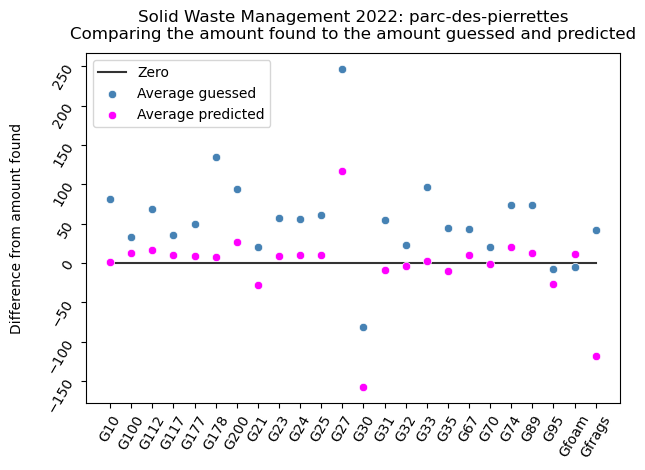

In [37]:
fig, ax = plt.subplots()


data = nl_pp[["code", "found", "guessed-diff", "predicted-diff"]].copy()
x= data["code"].values
y=data["guessed-diff"].values
y2 = data["predicted-diff"].values

y_sqd = np.sqrt(y**2)
y2_sqd = y2**2

ty = [np.sqrt(x) for x in y2_sqd]

xmax = len(x)

sns.lineplot(x=x, y=np.zeros(len(x)), color="black", alpha=0.8, label="Zero", zorder=0)
sns.scatterplot(x=x, y=y, label = "Average guessed", color="steelblue", ax=ax, zorder=2)
sns.scatterplot(x=x, y=y2, label = "Average predicted", color="magenta", ax=ax, zorder=2)

ax.tick_params(axis="both", which="both", labelsize=10, rotation=60)
ax.set_ylabel("Difference from amount found", labelpad=15)
ax.set_title("Solid Waste Management 2022: parc-des-pierrettes\nComparing the amount found to the amount guessed and predicted", pad=10)
ax.legend(bbox_to_anchor=(0,1), loc="upper left")
plt.tight_layout()
plt.savefig("differences_predicted_guessed_ppnl.jpeg", dpi=300)
plt.show()

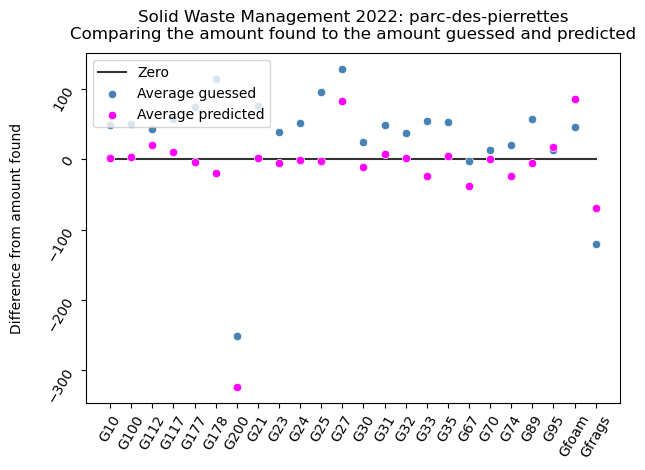

In [38]:
fig, ax = plt.subplots()


data = nl_sp[["code", "found", "guessed-diff", "predicted-diff"]].copy()
x= data["code"].values
y=data["guessed-diff"].values
y2 = data["predicted-diff"].values

y_sqd = np.sqrt(y**2)
y2_sqd = y2**2

ty = [np.sqrt(x) for x in y2_sqd]

xmax = len(x)

sns.lineplot(x=x, y=np.zeros(len(x)), color="black", alpha=0.8, label="Zero", zorder=0)
sns.scatterplot(x=x, y=y, label = "Average guessed", color="steelblue", ax=ax, zorder=2)
sns.scatterplot(x=x, y=y2, label = "Average predicted", color="magenta", ax=ax, zorder=2)

ax.tick_params(axis="both", which="both", labelsize=10, rotation=60)
ax.set_ylabel("Difference from amount found", labelpad=15)
ax.set_title("Solid Waste Management 2022: parc-des-pierrettes\nComparing the amount found to the amount guessed and predicted", pad=10)
ax.legend(bbox_to_anchor=(0,1), loc="upper left")
plt.tight_layout()
plt.savefig("differences_predicted_guessed_spnl.jpeg", dpi=300)
plt.show()